# Machine Learning with FastAI - Lesson 2
#### Bruno Martins Valério Bomfim, 211039297

## Purpose

In this article, we are going to train an AI model that can differentiate between images of a star, a planet and an asteroid. The **main purpose is to learn how to deploy a model** in production using HuggingFace services. 

## Collecting data from duckduckgo

#### Importing all required libraries


In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Downloading images within images folder.

In [ ]:
searches = 'star in space','planet', 'asteroid'
path = Path('images')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo', 100))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'star in space photo'
Searching for 'planet photo'
Searching for 'asteroid photo'


## Training the model

#### Cleaning failed images

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

Let's put the images into a datablock (that contains a training set and a validation set).

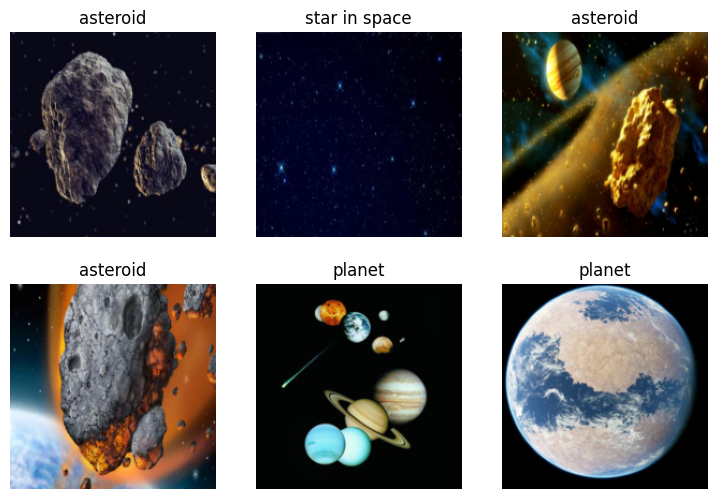

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.093376,0.224852,0.074380,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.169263,0.105140,0.016529,01:40
1,0.097048,0.126679,0.016529,01:40
2,0.065582,0.088948,0.016529,01:45
3,0.047808,0.078466,0.016529,01:50


## Using and testing the model (inference)

Let's test an image of a planet. This is Arrakis, a desert planet concepted by Frank Hebert, which became famous because of movie "Dune".

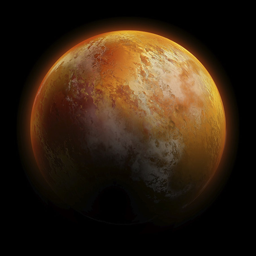

In [ ]:
Image.open('testing/arrakis.jpeg').to_thumb(256, 256)

In [ ]:
category,_,probs = learn.predict(PILImage.create('testing/arrakis.jpeg'))
print(f"This is a: {category}.")
print(f"Probability it's an asteroid: {probs[0]:.10f}")
print(f"Probability it's a planet: {probs[1]:.10f}")
print(f"Probability it's a star: {probs[2]:.10f}")

This is a: planet.
Probability it's an asteroid: 0.0000032845
Probability it's a planet: 0.9999812841
Probability it's a star: 0.0000153458


Ok, it worked as spected. Now let's try a random image of an asteroid:

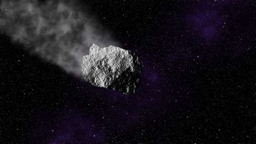

In [ ]:
Image.open('testing/asteroid.jpg').to_thumb(256, 256)

In [ ]:
category,_,probs = learn.predict(PILImage.create('testing/asteroid.jpg'))
print(f"This is a: {category}.")
print(f"Probability it's an asteroid: {probs[0]:.10f}")
print(f"Probability it's a planet: {probs[1]:.10f}")
print(f"Probability it's a star: {probs[2]:.10f}")

This is a: asteroid.
Probability it's an asteroid: 0.9998425245
Probability it's a planet: 0.0000095439
Probability it's a star: 0.0001479454


It worked, as well. Now we gonna test a sun image.

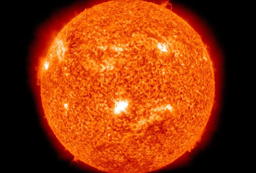

In [ ]:
Image.open('testing/sun.jpg').to_thumb(256, 256)

In [ ]:
category,_,probs = learn.predict(PILImage.create('testing/star.jpg'))
print(f"This is a: {category}.")
print(f"Probability it's an asteroid: {probs[0]:.10f}")
print(f"Probability it's a planet: {probs[1]:.10f}")
print(f"Probability it's a star: {probs[2]:.10f}")

This is a: star in space.
Probability it's an asteroid: 0.0038322166
Probability it's a planet: 0.2854651809
Probability it's a star: 0.7107026577


We've got almost 75%. Maybe it happend because I searched for "star in space" images, and not specificaly for "sun images". However, that's an ok percentage. Let's go ahead.

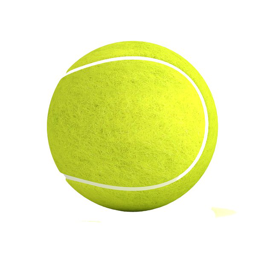

In [ ]:
Image.open('testing/tennis.jpg').to_thumb(256, 256)

In [ ]:
category,_,probs = learn.predict(PILImage.create('testing/tennis.jpg'))
print(f"This is a: {category}.")
print(f"Probability it's an asteroid: {probs[0]:.10f}")
print(f"Probability it's a planet: {probs[1]:.10f}")
print(f"Probability it's a star: {probs[2]:.10f}")

This is a: planet.
Probability it's an asteroid: 0.0000022104
Probability it's a planet: 0.9999943972
Probability it's a star: 0.0000033371


This is a tennis ball. Perhaps, our model have classified it as a "planet" because of its rounded shape and green color (many planet have green surfaces).

## Deployment

Exporting the model:

In [ ]:
learn.export("model.pkl")

You can check it out [here](https://huggingface.co/spaces/brunomartins/lesson2).

## Bibliographic Reference

[Jeremy Howard and Sylvain Gugge - FastBook](https://github.com/fastai/fastbook)